## Prophet prediction for NYC electricity load & price

In [1]:
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [2]:
df_price = pd.read_csv('nyiso_price_2017.csv', parse_dates=['time_stamp', 'time_stamp_local'])
df_load = pd.read_csv('nyiso_load_2017.csv', parse_dates=['time_stamp', 'time_stamp_local'])

In [3]:
df_price.shape, df_load.shape

((113161, 3), (106168, 3))

In [4]:
may1st_index_price = df_price.time_stamp_local >= pd.datetime(2017, 5, 1)
may1st_index_load = df_load.time_stamp_local >= pd.datetime(2017, 5, 1)

df_price = df_price.loc[may1st_index_price, :]
df_load = df_load.loc[may1st_index_load, :]

df_price.shape, df_load.shape

((78307, 3), (78307, 3))

In [5]:
df_price.head()

,time_stamp,lbmp_price,time_stamp_local
34854,2017-05-01 04:00:00,15.28,2017-05-01 00:00:00
34855,2017-05-01 04:05:00,14.21,2017-05-01 00:05:00
34856,2017-05-01 04:10:00,11.81,2017-05-01 00:10:00
34857,2017-05-01 04:15:00,15.27,2017-05-01 00:15:00
34858,2017-05-01 04:20:00,15.27,2017-05-01 00:20:00


In [6]:
df_price['lbmp_price_scaled'] = preprocessing.scale(df_price.lbmp_price)
df_load['load_scaled'] = preprocessing.scale(df_load.load)

In [7]:
df_price.drop(['time_stamp_local', 'lbmp_price'], axis = 1, inplace = True)
df_load.drop(['time_stamp_local', 'load'], axis = 1, inplace = True)

In [8]:
df_load.head()

,time_stamp,load_scaled
27861,2017-05-01 04:00:00,-1.369102
27862,2017-05-01 04:05:00,-1.403841
27863,2017-05-01 04:10:00,-1.411184
27864,2017-05-01 04:15:00,-1.425711
27865,2017-05-01 04:20:00,-1.440555


In [9]:
df_price.columns = ['ds', 'y']
df_load.columns = ['ds', 'y']

In [10]:
df_load.tail()

,ds,y
106163,2018-01-25 18:30:00,0.470679
106164,2018-01-25 18:35:00,0.467126
106165,2018-01-25 18:40:00,0.477627
106166,2018-01-25 18:45:00,0.475890
106167,2018-01-25 18:50:00,0.462783


(-3, 3)

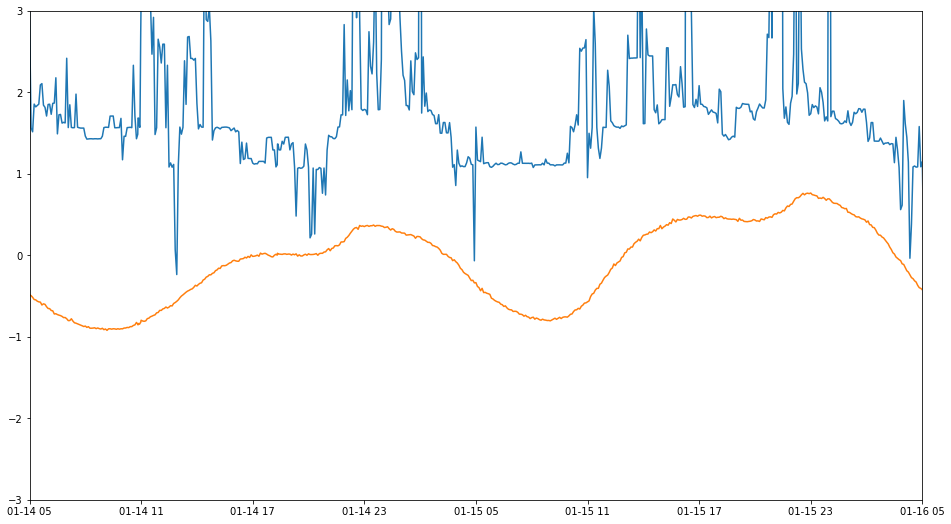

In [20]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(df_price.iloc[:,0], df_price.iloc[:,1])
ax.plot(df_load.iloc[:,0], df_load.iloc[:,1])
plt.xlim(pd.datetime(2018,1,14,5), pd.datetime(2018,1,16,5))
plt.ylim(-3, 3)

In [19]:
df_price.shape

(78307, 2)

In [12]:
percentage = 0.9

In [24]:
m = Prophet()
m.fit(df_price.iloc[:int(df_price.shape[0] * percentage), :]);
# future = m.make_future_dataframe(periods=12)
future = df_price.iloc[int(df_price.shape[0] * percentage):, :].drop('y', axis = 1)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [26]:
forecast.shape, int(df_price.shape[0] * percentage)

((7831, 19), 70476)

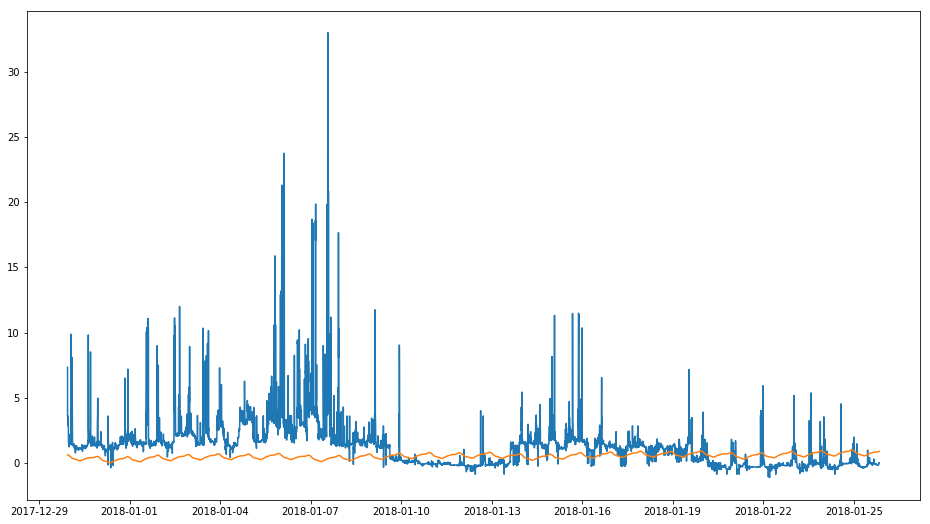

In [29]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(df_price.iloc[int(df_price.shape[0] * percentage):, 0], df_price.iloc[int(df_price.shape[0] * percentage):, 1]);
ax.plot(forecast.ds, forecast.yhat);

In [30]:
mean_squared_error(forecast.yhat.values, df_price.iloc[int(df_price.shape[0] * percentage):, 1].values)

5.0226488325164906

In [ ]:
# forecast.to_csv('forecast' + 'nyiso_2016_2017.csv', index = False)

In [41]:
m = Prophet()
m.fit(df_load.iloc[:int(df_load.shape[0] * percentage), :]);
# future = m.make_future_dataframe(periods=12)
future = df_load.iloc[int(df_load.shape[0] * percentage):, :].drop('y', axis = 1)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [42]:
mean_squared_error(forecast.yhat.values, df_load.iloc[int(df_load.shape[0] * percentage):, 1].values)

0.23449154117214535

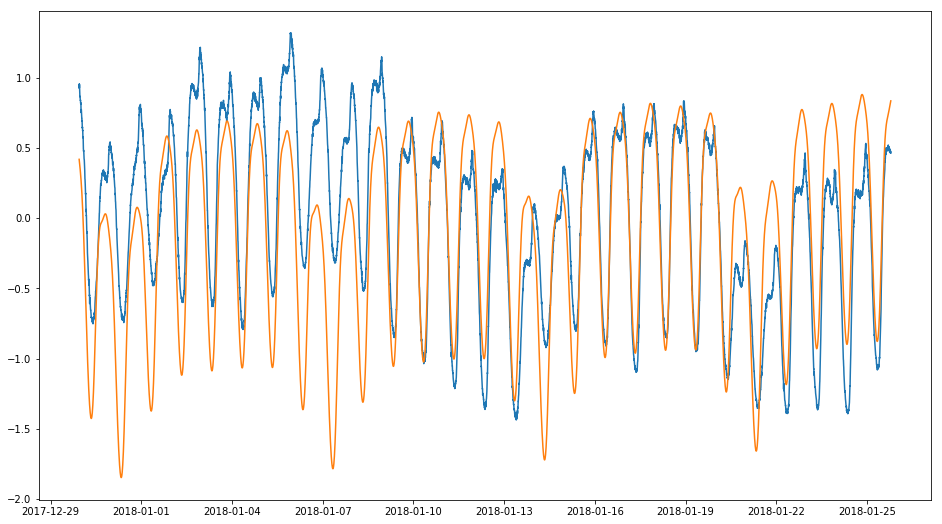

In [43]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(df_load.iloc[int(df_load.shape[0] * percentage):, 0], df_load.iloc[int(df_load.shape[0] * percentage):, 1]);
ax.plot(forecast.ds, forecast.yhat);